#### Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Prophet import (compatible with both packages names)
try:
    from prophet import Prophet
except Exception:
    # Older naming
    from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


#### Data

In [6]:
# Expect the same inputs used by SARIMA_v2.ipynb
# - merged-df.csv  (transactions with columns: user_id, amount, date, etc.)
# - final_features_with_clusters.csv (user_id -> Cluster mapping)

tx = pd.read_csv("merged-df.csv")
users = pd.read_csv("final_features_with_clusters.csv")

print("tx shape:", tx.shape)
print("users shape:", users.shape)
print("tx columns:", tx.columns.tolist())
print("users columns:", users.columns.tolist())


tx shape: (13305915, 36)
users shape: (1219, 33)
tx columns: ['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'description', 'category', 'user_current_age', 'user_retirement_age', 'user_birth_year', 'user_birth_month', 'user_gender', 'user_address', 'user_latitude', 'user_longitude', 'user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'user_credit_score', 'user_num_credit_cards', 'card_card_brand', 'card_card_type', 'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued', 'card_credit_limit', 'card_acct_open_date', 'card_year_pin_last_changed', 'card_card_on_dark_web']
users columns: ['user_id', 'total_txn_count', 'total_amount', 'avg_amount', 'std_amount', 'median_amount', 'first_txn', 'last_txn', 'user_gender', 'user_current_age', 'user_birth_year', 'user_yearly_income', 'user_per_capita_income', 'user_credit_score', 'user_total_debt', 'user_retirement_age', 'user_birth_m

#### Final df with clusters

In [8]:
tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
cluster_map = users[['user_id', 'Cluster']].drop_duplicates()
df = tx.merge(cluster_map, on='user_id', how='left')
df.head()


,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web,Cluster
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0000,Swipe Transaction,59935,Beulah,ND,58523,...,Debit (Prepaid),YES,306,2022-07-01,2,55.0000,2008-05-01,2008,No,3
1,7475328,2010-01-01 00:02:00,561,4575,14.5700,Swipe Transaction,67570,Bettendorf,IA,52722,...,Credit,YES,438,2024-12-01,1,"9,100.0000",2005-09-01,2015,No,3
2,7475329,2010-01-01 00:02:00,1129,102,80.0000,Swipe Transaction,27092,Vista,CA,92084,...,Debit,YES,256,2020-05-01,1,"14,802.0000",2006-01-01,2008,No,2
3,7475331,2010-01-01 00:05:00,430,2860,200.0000,Swipe Transaction,27092,Crown Point,IN,46307,...,Debit,NO,54,2024-10-01,2,"37,634.0000",2004-05-01,2006,No,0
4,7475332,2010-01-01 00:06:00,848,3915,46.4100,Swipe Transaction,13051,Harwood,MD,20776,...,Debit,YES,120,2020-01-01,1,"19,113.0000",2009-07-01,2014,No,2


#### exclude refunds (negative amounts)

In [11]:
before = len(df)
df = df[df['amount'] > 0].copy()
after = len(df)
print(f"Removed refunds: {before-after:,} rows ({100*(before-after)/before:.2f}%)")


Removed refunds: 670,688 rows (5.04%)


#### Aggregate to Cluster × Month (target series)

In [13]:
cluster_monthly = (
    df.groupby(['Cluster', pd.Grouper(key='date', freq='M')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'amount':'total_amount'})
      .sort_values(['Cluster','date'])
)

# Align to month-end (consistent with SARIMA_v2.ipynb)
cluster_monthly['date'] = pd.to_datetime(cluster_monthly['date']).dt.to_period('M').dt.to_timestamp('M')
cluster_monthly.head()


,Cluster,date,total_amount
0,0,2010-01-31,"1,292,104.0400"
1,0,2010-02-28,"1,227,733.5800"
2,0,2010-03-31,"1,347,335.9600"
3,0,2010-04-30,"1,300,306.2700"
4,0,2010-05-31,"1,333,779.1400"


### No missing months in df

In [15]:
def expected_months_count(start_ts, end_ts):
    return len(pd.period_range(start=start_ts, end=end_ts, freq='M'))

ranges = (
    cluster_monthly.groupby('Cluster')['date']
    .agg(start='min', end='max')
    .reset_index()
)
ranges['expected_months'] = ranges.apply(lambda r: expected_months_count(r['start'], r['end']), axis=1)
counts = cluster_monthly.groupby('Cluster')['date'].nunique().reset_index(name='actual_months')
ranges = ranges.merge(counts, on='Cluster', how='left')
ranges['missing?'] = ranges['expected_months'] != ranges['actual_months']
ranges


,Cluster,start,end,expected_months,actual_months,missing?
0,0,2010-01-31,2019-10-31,118,118,False
1,1,2010-01-31,2019-10-31,118,118,False
2,2,2010-01-31,2019-10-31,118,118,False
3,3,2010-01-31,2019-10-31,118,118,False


#### Quick EDA of composition

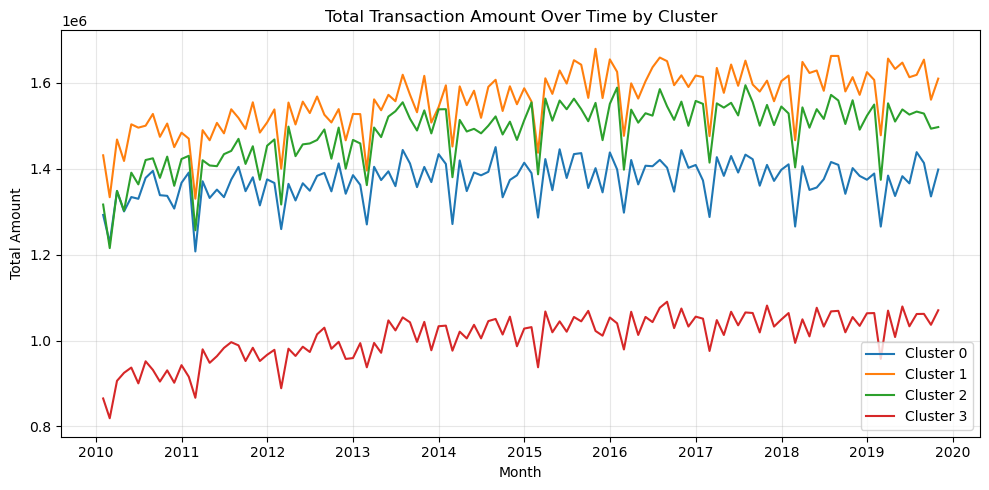

In [17]:
plt.figure(figsize=(10,5))
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c]
    plt.plot(sub['date'], sub['total_amount'], label=f'Cluster {c}')
plt.title('Total Transaction Amount Over Time by Cluster')
plt.xlabel('Month'); plt.ylabel('Total Amount')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


### Exploratory Analysis

#### 1. Total Spending Variation per Cluster

In [20]:
stats_by_cluster = cluster_monthly.groupby('Cluster')['total_amount'].agg(['mean','std','min','max']).reset_index()
stats_by_cluster


,Cluster,mean,std,min,max
0,0,"1,371,480.8090","47,418.3176","1,207,193.9200","1,449,980.8600"
1,1,"1,557,327.0026","71,212.9679","1,329,875.4100","1,678,666.3200"
2,2,"1,481,842.1126","72,873.3805","1,214,996.9800","1,593,976.3900"
3,3,"1,007,609.0980","54,332.5489","819,140.5900","1,090,187.5700"


#### 2. Rolling Mean & Variance per Cluster

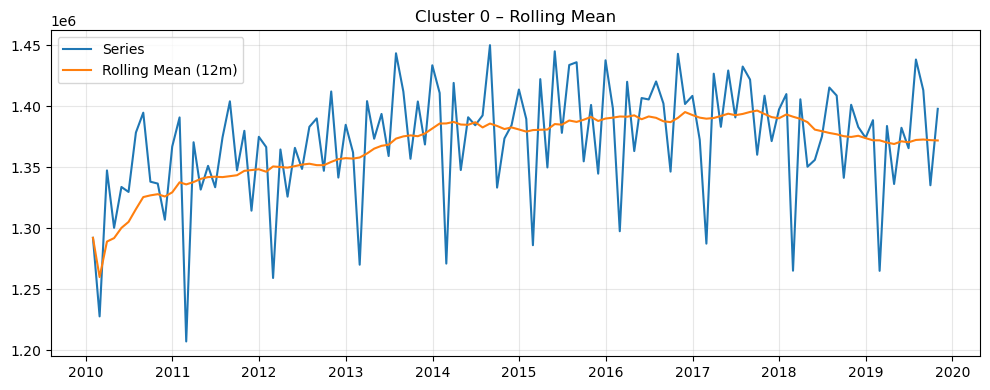

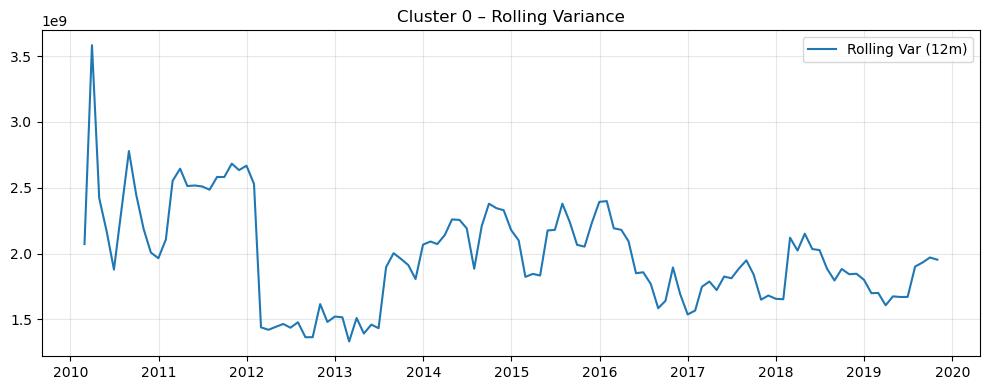

In [22]:
def rolling_stats(ts, window=12):
    rm = ts.rolling(window=window, min_periods=1).mean()
    rv = ts.rolling(window=window, min_periods=1).var()
    return rm, rv

cid = sorted(cluster_monthly['Cluster'].unique())[0]
ts0 = (cluster_monthly.query("Cluster == @cid")
                    .set_index('date')['total_amount']
                    .asfreq('M').dropna())

rm, rv = rolling_stats(ts0, window=12)
plt.figure(figsize=(10,4))
plt.plot(ts0.index, ts0.values, label='Series')
plt.plot(rm.index, rm.values, label='Rolling Mean (12m)')
plt.title(f'Cluster {cid} – Rolling Mean'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(rv.index, rv.values, label='Rolling Var (12m)')
plt.title(f'Cluster {cid} – Rolling Variance'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


#### 3. Seasonal-Trend Decomposition (STL)

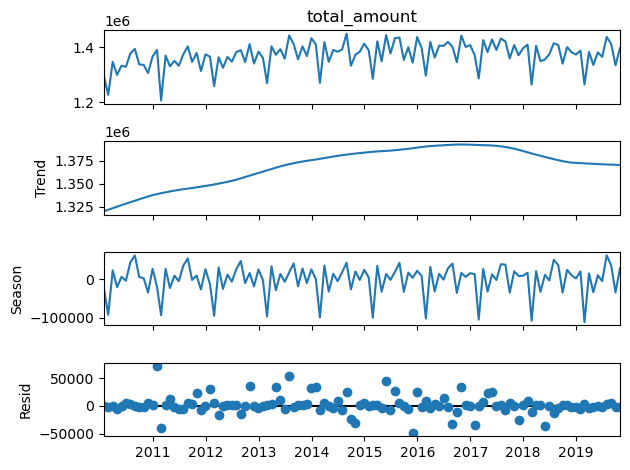

In [24]:
stl = STL(ts0, robust=True, period=12).fit()
fig = stl.plot()
plt.tight_layout(); plt.show()


#### Formal Stationarity Check

In [26]:
def adf_kpss_summary(ts):
    ts = ts.dropna()
    adf_stat, adf_p, *_ = adfuller(ts)
    kpss_stat, kpss_p, *_ = kpss(ts, regression='c', nlags='auto')
    return {
        'ADF_Statistic': adf_stat, 'ADF_pvalue': adf_p,
        'KPSS_Statistic': kpss_stat, 'KPSS_pvalue': kpss_p
    }

adf_kpss_summary(ts0)


{'ADF_Statistic': -2.795269800049193,
 'ADF_pvalue': 0.05895262667329218,
 'KPSS_Statistic': 1.1518324168847236,
 'KPSS_pvalue': 0.01}

#### Prophet helpers (prep & evaluation)

In [36]:
def to_prophet_frame(ts):
    dfp = ts.reset_index().rename(columns={'date':'ds','total_amount':'y'})
    return dfp

def fit_prophet(dfp, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0):
    m = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    # Monthly data: add monthly seasonality explicitly
    m.add_seasonality(name='monthly', period=12, fourier_order=5)
    m.fit(dfp)
    return m

def prophet_forecast(m, periods=12, freq='M'):
    future = m.make_future_dataframe(periods=periods, freq=freq, include_history=True)
    fc = m.predict(future)
    return fc

def rolling_forecast_prophet(ts, train_len=84, horizon=1, step=1,
                             **prophet_kwargs):
    """Walk-forward 1-step (or multi-step) evaluation, mirroring SARIMA's rolling_forecast."""
    ts = ts.dropna()
    n = len(ts)
    preds, actuals, dates = [], [], []
    values = ts.values
    idx = ts.index

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test = ts.iloc[start + train_len : start + train_len + horizon]

        dfp = train.to_frame(name='total_amount')
        dfp = to_prophet_frame(dfp)

        m = fit_prophet(dfp, **prophet_kwargs)
        future = m.make_future_dataframe(periods=horizon, freq='M', include_history=False)
        fc = m.predict(future)

        preds.extend(fc['yhat'].values.tolist())
        actuals.extend(test.values.tolist())
        dates.extend(test.index.tolist())

    res = pd.DataFrame({'date': dates, 'actual': actuals, 'pred': preds}).set_index('date')
    return res

def metrics_from_df(res):
    mae = mean_absolute_error(res['actual'], res['pred'])
    rmse = mean_squared_error(res['actual'], res['pred'], squared=False)
    mape = mean_absolute_percentage_error(res['actual'], res['pred'])
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


#### Example (one cluster) – rolling evaluation with Prophet

11:46:41 - cmdstanpy - INFO - Chain [1] start processing
11:46:41 - cmdstanpy - INFO - Chain [1] done processing
11:46:41 - cmdstanpy - INFO - Chain [1] start processing
11:46:41 - cmdstanpy - INFO - Chain [1] done processing
11:46:41 - cmdstanpy - INFO - Chain [1] start processing
11:46:41 - cmdstanpy - INFO - Chain [1] done processing
11:46:41 - cmdstanpy - INFO - Chain [1] start processing
11:46:42 - cmdstanpy - INFO - Chain [1] done processing
11:46:42 - cmdstanpy - INFO - Chain [1] start processing
11:46:42 - cmdstanpy - INFO - Chain [1] done processing
11:46:42 - cmdstanpy - INFO - Chain [1] start processing
11:46:42 - cmdstanpy - INFO - Chain [1] done processing
11:46:42 - cmdstanpy - INFO - Chain [1] start processing
11:46:43 - cmdstanpy - INFO - Chain [1] done processing
11:46:43 - cmdstanpy - INFO - Chain [1] start processing
11:46:43 - cmdstanpy - INFO - Chain [1] done processing
11:46:43 - cmdstanpy - INFO - Chain [1] start processing
11:46:43 - cmdstanpy - INFO - Chain [1]

{'MAE': 13888.86811426925, 'RMSE': 18035.435582298356, 'MAPE': 0.010077355464180189}


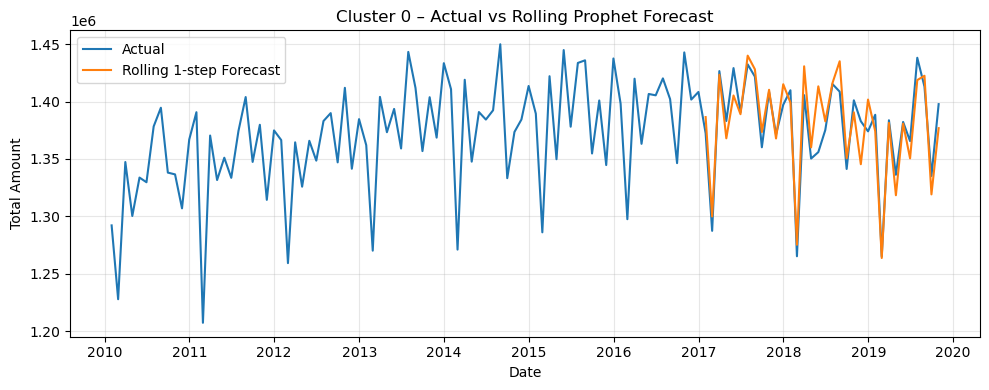

In [42]:
cid = sorted(cluster_monthly['Cluster'].unique())[0]
ts = (cluster_monthly.query("Cluster == @cid")
        .set_index('date')['total_amount'].asfreq('M').dropna())

res = rolling_forecast_prophet(ts, train_len=84, horizon=1, step=1,
                               yearly_seasonality=True, seasonality_mode='additive',
                               changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)
print(metrics_from_df(res))

plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, label='Actual')
plt.plot(res.index, res['pred'], label='Rolling 1-step Forecast')
plt.title(f'Cluster {cid} – Actual vs Rolling Prophet Forecast')
plt.xlabel('Date'); plt.ylabel('Total Amount'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


#### Prophet simple hyperparameter search 

In [43]:
def prophet_grid_search(ts, grid):
    results = []
    for cps in grid.get('changepoint_prior_scale', [0.05]):
        for sps in grid.get('seasonality_prior_scale', [10.0]):
            res = rolling_forecast_prophet(
                ts, train_len=84, horizon=1, step=1,
                yearly_seasonality=True, seasonality_mode='additive',
                changepoint_prior_scale=cps, seasonality_prior_scale=sps
            )
            met = metrics_from_df(res)
            met.update({'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps})
            results.append(met)
    return pd.DataFrame(results).sort_values('RMSE')

# Example (commented; uncomment to run):
grid = {'changepoint_prior_scale': [0.01, 0.05, 0.1],
        'seasonality_prior_scale': [5.0, 10.0, 15.0]}
prophet_grid_search(ts, grid)


11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:51 - cmdstanpy - INFO - Chain [1] done processing
11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:51 - cmdstanpy - INFO - Chain [1] done processing
11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:51 - cmdstanpy - INFO - Chain [1] done processing
11:46:51 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing
11:46:52 - cmdstanpy - INFO - Chain [1] start processing
11:46:53 - cmdstanpy - INFO - Chain [1] done processing
11:46:53 - cmdstanpy - INFO - Chain [1] start processing
11:46:53 - cmdstanpy - INFO - Chain [1]

,MAE,RMSE,MAPE,changepoint_prior_scale,seasonality_prior_scale
7,"13,642.4142","17,697.5901",0.0099,0.1000,10.0000
6,"13,657.4233","17,714.0094",0.0099,0.1000,5.0000
8,"13,646.6470","17,728.2054",0.0099,0.1000,15.0000
3,"13,934.2886","17,975.2265",0.0101,0.0500,5.0000
5,"13,788.9682","17,982.9040",0.0100,0.0500,15.0000
4,"13,888.8681","18,035.4356",0.0101,0.0500,10.0000
2,"14,670.7720","19,063.8049",0.0107,0.0100,15.0000
0,"14,706.9594","19,099.9691",0.0107,0.0100,5.0000
1,"14,705.4165","19,142.5054",0.0107,0.0100,10.0000


#### Fit final Prophet per cluster and forecast next 12 months

In [44]:
def fit_and_forecast_all_clusters(cluster_monthly, periods=12, prophet_kwargs=None):
    if prophet_kwargs is None:
        prophet_kwargs = dict(yearly_seasonality=True, seasonality_mode='additive',
                              changepoint_prior_scale=0.05, seasonality_prior_scale=10.0)

    forecasts = {}
    for cid in sorted(cluster_monthly['Cluster'].unique()):
        ts = (cluster_monthly.query("Cluster == @cid")
                .set_index('date')['total_amount']
                .asfreq('M').dropna())

        dfp = ts.to_frame(name='total_amount')
        dfp = dfp.reset_index().rename(columns={'date':'ds', 'total_amount':'y'})

        m = fit_prophet(dfp, **prophet_kwargs)
        fc = prophet_forecast(m, periods=periods, freq='M')
        forecasts[cid] = {'model': m, 'forecast': fc, 'history': dfp}
    return forecasts

forecasts = fit_and_forecast_all_clusters(cluster_monthly, periods=12)
list(forecasts.keys())[:5]


11:48:13 - cmdstanpy - INFO - Chain [1] start processing
11:48:13 - cmdstanpy - INFO - Chain [1] done processing
11:48:13 - cmdstanpy - INFO - Chain [1] start processing
11:48:13 - cmdstanpy - INFO - Chain [1] done processing
11:48:13 - cmdstanpy - INFO - Chain [1] start processing
11:48:13 - cmdstanpy - INFO - Chain [1] done processing
11:48:13 - cmdstanpy - INFO - Chain [1] start processing
11:48:13 - cmdstanpy - INFO - Chain [1] done processing


[0, 1, 2, 3]

#### Overlays by cluster – Actual vs Prophet forecast

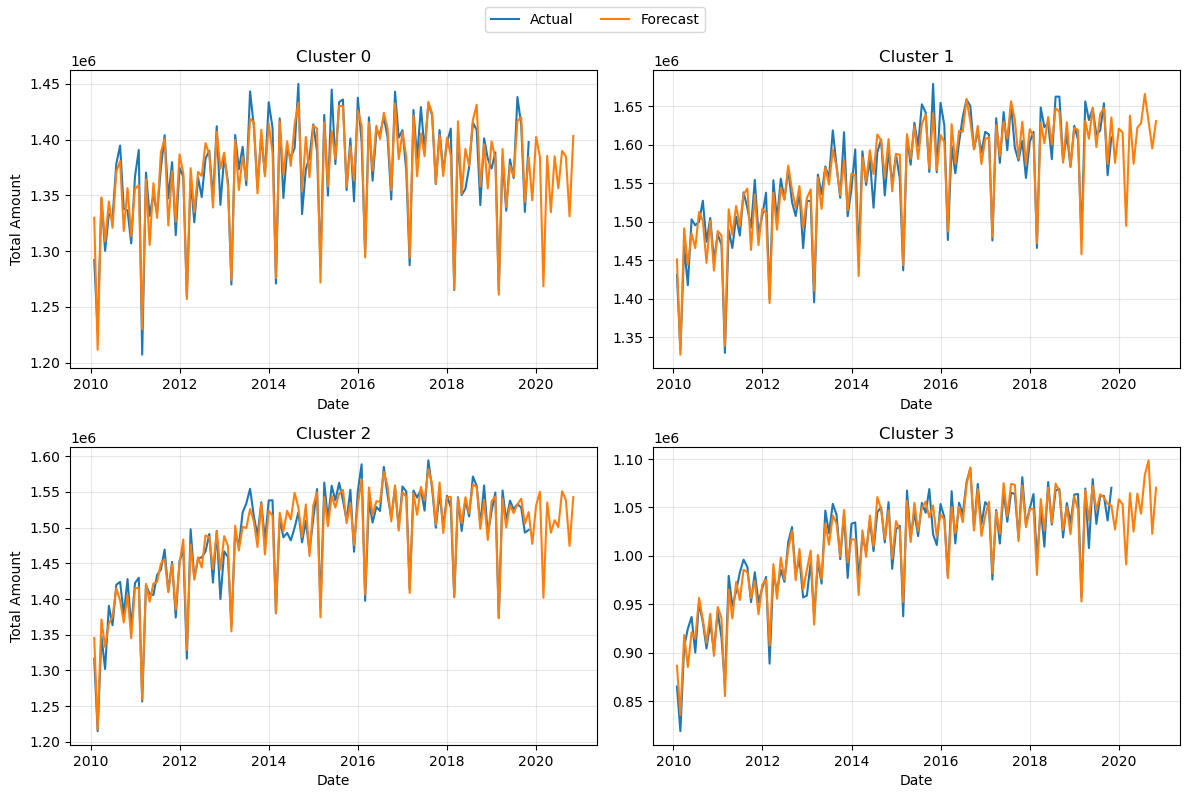

In [45]:
def plot_overlays(forecasts, cluster_monthly):
    cids = sorted(forecasts.keys())
    cols = 2
    rows = (len(cids) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)

    for i, cid in enumerate(cids):
        ax = axes[i // cols][i % cols]
        ts = (cluster_monthly.query("Cluster == @cid")
                .set_index('date')['total_amount'].asfreq('M').dropna())

        fc = forecasts[cid]['forecast']
        ax.plot(ts.index, ts.values, label='Actual')
        ax.plot(pd.to_datetime(fc['ds']), fc['yhat'], label='Forecast')
        ax.set_title(f'Cluster {cid}')
        ax.grid(alpha=0.3)
        if i % cols == 0: ax.set_ylabel('Total Amount')
        ax.set_xlabel('Date')

    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

plot_overlays(forecasts, cluster_monthly)


#### Prophet components (example cluster)

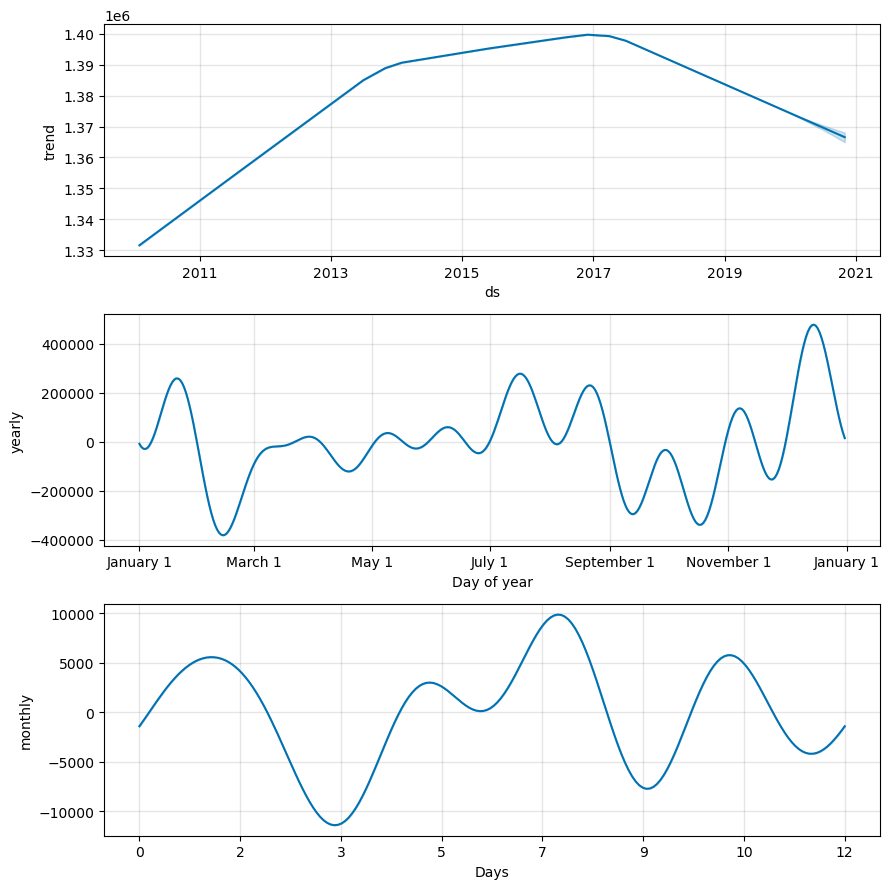

In [47]:
cid = sorted(forecasts.keys())[0]
m = forecasts[cid]['model']
fc = forecasts[cid]['forecast']
_ = m.plot_components(fc)
plt.tight_layout(); plt.show()
